In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
Image.LOAD_TRUNCATED_IMAGES = True

import timm
import torchvision.transforms as transforms

import shutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/dlit/miniconda3/envs/pgn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def predict_image(model, input_image):
    model.eval()
    with torch.no_grad():
        outputs = model(input_image)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        return predicted, confidence

def predict(model, image, transform, normalize=False):
    # image = Image.open(path)
    # image = image.convert("RGB")
    if normalize:
        augmented = transform(image=np.array(image))
        image_rgb = augmented["image"].unsqueeze(0)
    else:
        image_rgb = transform(image).unsqueeze(0)
    
    
    image_rgb = image_rgb.to(device)
    
    predicted_class, confidence = predict_image(model, image_rgb)
    pred = predicted_class.item()
    
    pred_result = class_mapping[str(pred)]
    return pred_result, confidence

In [3]:
class_mapping = {
            '0': '27_30',
            '1': '27_45',
            '2': '28',
            '3': '31'
        }

ad_class_mapping = {
            '27_30' : '0',
            '27_45' : '1',
            '28' : '2',
            '31' : '3'
        }

In [4]:
# 모델 불러오기 및 가중치 불러오기(inception, 1step활용)
model1 = timm.create_model('inception_v4', pretrained=False)
in_features = model1.last_linear.in_features
num_classes = 4
model1.last_linear = nn.Linear(in_features, num_classes)
model1.load_state_dict(torch.load('../model/inception_v4_final.pth'))

model1 = model1.to(device)

resize = 299
transform1 = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor()
])

In [5]:
# 모델 불러오기 및 가중치 불러오기 (mobilenet, 2step활용)
model2 = models.mobilenet_v3_small(pretrained=False)
num_classes = 4
model2.classifier[3] = nn.Linear(model2.classifier[3].in_features, num_classes)
model2.load_state_dict(torch.load('../model/mobilenetv3_with_smote_multi_3.pth'))
model2 = model2.to(device)

transform2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

/home/dlit/miniconda3/envs/pgn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dlit/miniconda3/envs/pgn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [80]:
model3 = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=2)
model3.load_state_dict(torch.load('/home/dlit/works/pgn/seohan/model_create/new_model/epoch_016_val_100.00.pt')['model_state_dict'])

model3 = model3.to(device)

model4 = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=2)
model4.load_state_dict(torch.load('../model/inception_resnet_v2_2class_2_final_ll.pth'))

model4 = model4.to(device)

resize = 299

transform3 = A.Compose([
    A.Resize(299, 299),
    A.Normalize(),
    ToTensorV2()
])

In [122]:
# data_dir = '/home/dlit_ai/seohan/test_data/testdata_240227/'
data_dir = '/mnt/nas/seohan_image/test_data/testdata_250107/'

# 상위 폴더 내의 하위 폴더 목록을 가져옵니다.
subdirectories = [os.path.join(data_dir, o) for o in os.listdir(data_dir) 
                  if  os.path.isdir(os.path.join(data_dir,o))]

y_test = []
predicted_class = []
wrong_label = []
predict2 = []
wrong_file = []
wrong_file1 = []

for subdir in subdirectories:  
    files = [f for f in os.listdir(subdir) if os.path.isfile(os.path.join(subdir, f))]
    folder_label = subdir.split('/')[-1]
    su_folder_label = ad_class_mapping[folder_label]
    correct = folder_label
    
    for file in files:
        image = Image.open(subdir+'/'+file)
        image = image.convert("RGB")

        result, confidence = predict(model1, image, transform1)
        if correct != result:
            wrong_file1.append(os.path.join(correct, file))
            wrong_label.append(ad_class_mapping[correct])
            predict2.append(ad_class_mapping[result])
            
        if (not correct.startswith('27') or not result.startswith('27')) and correct != result:
            # print('inception Error', result, confidence)
            result, confidence = predict(model2, image, transform2)
            
        if result.startswith('27'):
            result, confidence = predict(model3, image, transform3, True)
            # if confidence < 0.9 or correct != result:
            #     result2, confidence2 = predict(model4, image, transform1)
            #     if confidence < confidence2:
            #         result = result2

        if correct != result :
            print(result, correct, confidence, file)
            wrong_file.append(os.path.join(correct, file))
        # if correct != result or confidence.item() < 0.85:
        #     print(file, correct, result, confidence)
        #     wrong_file1.append(file)
        #     wrong_label.append(ad_class_mapping[correct])
        #     if result in ['28', '31']:
        #         result, confidence = predict(model2, image, transform2)
                
        #     if result in ['27_30', '27_45']:
        #         result, confidence = predict(model3, image, transform1)

        #     predict2.append(ad_class_mapping[result])
        #     if correct != result :
        #         wrong_file.append(file)

        y_test.append(su_folder_label)
        predicted_class.append(ad_class_mapping[result])


27_45 28 tensor([0.9998], device='cuda:0') 20250107_020940_888_49538-95285.bmp


In [123]:
set(predicted_class)

{'0', '1', '2', '3'}

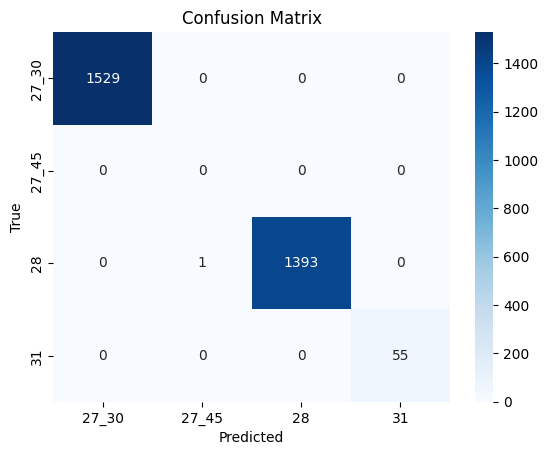

In [124]:
cm = confusion_matrix(y_test, predicted_class)
class_names = ['27_30', '27_45', '28', '31']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [125]:
wrong_file

['28/20250107_020940_888_49538-95285.bmp']

In [106]:
#1step에서 틀린것만
cm = confusion_matrix(wrong_label, predict2)
class_names = ['27_30', '27_45', '28', '31']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

In [73]:
wrong_file1

['27_30/20250104_005313_947_49748-95273.bmp',
 '27_30/20250104_010644_974_49748-95273.bmp',
 '27_30/20250104_014311_1044_49748-95273.bmp',
 '27_30/20250104_015905_1073_49748-95273.bmp',
 '27_30/20250104_020725_1095_49748-95273.bmp',
 '27_30/20250104_030145_1147_49748-95273.bmp',
 '27_30/20250104_030231_1149_49748-95273.bmp',
 '27_45/20250104_022325_259_49748-95270.bmp']

In [38]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
print(f1_score(y_test_cpu, predicted_class_cpu, average='micro'))
print(accuracy_score(y_test_cpu, predicted_class_cpu))

NameError: name 'y_test_cpu' is not defined